# VIP This notebook use data from `Fig3c.ipynb`

In [1]:
import os, sys, warnings

import numpy  as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context(context='poster')

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.monospace'] = 'Andale Mono'
# mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['mathtext.rm'] = 'Arial'
mpl.rcParams['mathtext.default'] = 'rm'

mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['text.usetex'] = False
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{wasysym}',
    r'\usepackage{amsmath}',
    r'\usepackage{amssymb}',
]

# mpl.rcParams['font.family'] = "sans-serif"
# mpl.rcParams['font.serif'] = 'serif'
# [f.name for f in mpl.font_manager.fontManager.ttflist if 'Mono' in f.name]

bigsize   = 20
midsize   = 20
smallsize = 15
hugesize  = 24

In [2]:
sys.path.append('.'); warnings.simplefilter(action='ignore', category=FutureWarning);

---

In [ ]:
from figdata import xlsx_tab, mmqc
from figdata import sample_colors, f1, f2, f3, f4

from figdata import xlsx_tab, cells_tab
from figdata import n_big_cnv, n_small_cnv

from pathlib import Path

from matplotlib.colors import Normalize

In [4]:
def fig1_barplot(axs, FSAMPLE=True):
#     fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(12,4), gridspec_kw={'height_ratios':[10,1],'hspace':0})

    thresh = 2e5
    three_colors = ['greyish', 'dusty purple', 'amber']
    # three_colors = ['greyish', 'faded green', 'windows blue']
    three_colors = sns.xkcd_palette(three_colors)
    
    folder = Path('/$MYPATH/scTn5/1k_SingleCell_Xten/hmmcopy/99.Save/01.bam_stat_list')

    sum_n = []
    idx = 0

    if FSAMPLE:
        fig_df = xlsx_tab.copy()
        fig_df = fig_df.set_index( np.arange(fig_df.shape[0]) )
        samples = xlsx_tab['SAMPLE']
    else:
        fig_df = xlsx_tab.copy().drop(11).replace('M11','M10')
        fig_df = fig_df.set_index( np.arange(fig_df.shape[0]) )
        samples = xlsx_tab['SAMPLE'].drop(11)

    n_ticks = []
    
    for n, s in enumerate( samples ):
        f = s+'.raw.list'
        tmp_df = pd.read_csv(folder/f, sep='\t', header=None ).rename(columns={0:'Name',1:'raw'})
        tmp_df['Name'] = tmp_df['Name'].str.replace('.total_reads.list:', '_')
        tmp_df['Lane'] = tmp_df['Name'].str.split('_',expand=True)[1]
        n_lane  = tmp_df['Lane'].unique().shape[0]
        n_get   = tmp_df.query('raw>@thresh').shape[0]
        n_blank = (n_lane*5*96 - n_get)

        x = idx+np.arange(0, n_lane*5*96)
        y = np.log10( 
            np.array(
                tmp_df.query('raw>@thresh').sort_values('raw',ascending=False)['raw'].tolist()
                +
                tmp_df.query('raw<@thresh').sort_values('raw',ascending=False)['raw'].tolist()[:n_blank]
            )
        )
        mid_p = x.mean()
        if FSAMPLE:
            color = sample_colors[n]
        elif n>9:
            color = sample_colors[n+1]
        else:
            color = sample_colors[n]
            
        axs[0].fill_between(x, y, 0, color=color, zorder=0)
#         axs[0].fill_between(x[y<np.log10(3e5)], np.log10(3e5), 0, facecolor='black', alpha=0.5, zorder=1, edgecolor=None)
        axs[0].text(mid_p, 7, fig_df.loc[n, 'CODE'], fontsize=smallsize, ha='center')
    
        a = cells_tab.loc[s,'n_harvest']
        b = cells_tab.loc[s,'n_reads']
    #     b = tmp_df.query('raw>@thresh').shape[0]
        c = cells_tab.loc[s,'n_pf']
        
        if len(sum_n) == 0:
            axs[1].broken_barh([(idx+b, a-b)], [0.5,1], color='black', edgecolor='k', label='Undetected')
            axs[1].broken_barh([(idx+c, b-c)], [0.5,1], color='gray',  edgecolor='k', label='Fail-QC')
            axs[1].broken_barh([(idx+0, c-0)], [0.5,1], color='white', edgecolor='k', label='Pass-QC')
        else:
            axs[1].broken_barh([(idx+b, a-b)], [0.5,1], color='black', edgecolor='k')
            axs[1].broken_barh([(idx+c, b-c)], [0.5,1], color='gray',  edgecolor='k')
            axs[1].broken_barh([(idx+0, c-0)], [0.5,1], color='white', edgecolor='k')
        
        n_ticks.append( (mid_p, c ) )
        
        sum_n.append(n_lane*5*96)
        idx += n_lane*5*96 + 10

    axs[0].set_ylim(0,8)
    axs[0].set_ylabel(r'Reads ($10^n$)', fontsize=bigsize)
#     axs[0].hlines(np.log10(3e5), 0, idx, linestyles='dashed', color='k', lw=2)
#     axs[0].text(idx, np.log10(3e5), ' 0.3M', ha='left', va='center', fontsize=midsize)

    axs[0].set_yticks([0,2,4,6,8])
    axs[0].set_yticklabels([0,2,4,6,8], fontsize=midsize)
    axs[0].tick_params(axis='y', labelsize=midsize, length=5)

    axs[0].set_title('Sequencing depth', fontsize=bigsize, pad=smallsize)

    axs[0].set_xlim(0,idx)
    axs[1].set_xlim(0,idx)
    axs[0].set_xticks( [] )
    
    axs[1].xaxis.set_major_locator(mpl.ticker.FixedLocator( [0,idx] ))
    axs[1].xaxis.set_minor_locator(mpl.ticker.FixedLocator( np.array(n_ticks)[:,0] ))
    axs[1].xaxis.set_major_formatter(mpl.ticker.FixedFormatter( ['#1', '#' + str(np.array(sum_n).sum())] ))
    axs[1].xaxis.set_minor_formatter(mpl.ticker.FixedFormatter( np.array(n_ticks)[:,1].astype(int) ))
    axs[1].tick_params(
        which='major', axis='x', labelsize=midsize, length=0
    )
    axs[1].tick_params(
        which='minor', axis='x', labelsize=smallsize, length=0, 
        labeltop=True, labelbottom=False, 
        rotation=45,
    )
    
    axs[1].set_ylim(0.2,1)
    axs[1].set_yticks([])

    axs[1].set_xlabel('Cell ID', labelpad=-1*smallsize, fontsize=bigsize)
    axs[1].spines['bottom'].set_visible(False)

    return

---
---
---

In [6]:
from figdata import ref, xlsx_tab, cells_tab, mmqc, good_df, sum_df
from figdata import sample_colors, good_pos, r_acen, chrf, bigCNV, big_cnv_idx, small_cnv_idx

from scipy import stats

from figdata import xlsx_tab, mmqc, sum_df
from figdata import sample_colors, good_pos, r_acen, chrf, bigCNV, f1, f2, f3, f4

from scipy.ndimage.filters import gaussian_filter

In [7]:
def fig2_plot(ax, FSAMPLE=True):
#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,6))

    two_colors = sns.xkcd_palette(['bright blue','red'])

    fig_df1 = pd.concat(
        [
            xlsx_tab.set_index('SAMPLE'),
            (
                sum_df.loc[big_cnv_idx]
                    .query('Space!="chrY" & Space!="chrX"')
                    .groupby(['Cell','Sample']).count().reset_index()
                    .groupby('Sample').count()['Cell']
            ),
            cells_tab['n_pf'],
        ], axis=1, sort=False
    )

    fig_df2 = pd.concat(
        [
            xlsx_tab.set_index('SAMPLE'),
            (
#                 sum_df.drop(big_cnv_idx)
                sum_df.loc[small_cnv_idx]
                    .query('r<@r_acen & Space!="chrY" & Space!="chrX"')
                    .groupby(['Cell','Sample']).count().reset_index()
                    .groupby('Sample').count()['Cell']
            ),
            cells_tab['n_pf'],
        ], axis=1, sort=False
    )

    fig_df1['Ratio'] = 100*fig_df1['Cell']/fig_df1['n_pf']
    fig_df2['Ratio'] = 100*fig_df2['Cell']/fig_df2['n_pf']

    if not FSAMPLE:
        fig_df1 = fig_df1.drop('$FSAMPLE').replace('M11','M10')
        fig_df2 = fig_df2.drop('$FSAMPLE').replace('M11','M10')

    ax.bar(
        0, 
        fig_df1.groupby('GENDER').mean().loc['male',  'Ratio'], 
        yerr=fig_df1.groupby('GENDER').std().loc['male',  'Ratio'], 
        edgecolor='k', color=two_colors[0], alpha=0.8
    )
    ax.bar(
        2, 
        fig_df1.groupby('GENDER').mean().loc['female','Ratio'], 
        yerr=fig_df1.groupby('GENDER').std().loc['female','Ratio'], 
        edgecolor='k', color=two_colors[1], alpha=0.8
    )

    ax.bar(
        1, 
        fig_df2.groupby('GENDER').mean().loc['male',  'Ratio'], 
        yerr=fig_df2.groupby('GENDER').std().loc['male',  'Ratio'], 
        edgecolor='k', color=two_colors[0], alpha=0.8
    )
    ax.bar(
        3, 
        fig_df2.groupby('GENDER').mean().loc['female','Ratio'], 
        yerr=fig_df2.groupby('GENDER').std().loc['female','Ratio'], 
        edgecolor='k', color=two_colors[1], alpha=0.8
    )

    ax.xaxis.set_minor_locator(mpl.ticker.FixedLocator([0.5,2.5]))
    ax.xaxis.set_minor_formatter(mpl.ticker.FixedFormatter(['$\u2642$','$\u2640$']))
#     ax.xaxis.set_minor_formatter(mpl.ticker.FixedFormatter([r'\male',r'\female']))

    ax.xaxis.set_major_locator(mpl.ticker.FixedLocator([0,1,2,3]))
    ax.set_xticklabels(('>10M', '$\leqslant$10M', '>10M', '$\leqslant$10M'), fontsize=midsize, rotation=45)

    ax.tick_params(which='major', length=5)
    ax.tick_params(which='minor', labelsize=hugesize, pad=3*hugesize, length=0)

    ax.set_xlabel('')
    ax.set_ylabel('% of cell with CNV', fontsize=midsize)

    ax.set_xlim(-0.5,3.5)
    ax.set_ylim(0,60)

    ax.tick_params(axis='y', labelsize=midsize, length=5)

    n_male = fig_df1.groupby('GENDER')['CODE'].count()['male']
    
    xa1 = stats.uniform(-0.1, 0.1 * 2).rvs(n_male)+0
    xa2 = stats.uniform(-0.1, 0.1 * 2).rvs(n_male)+1
    ya1 = fig_df1.query('GENDER=="male"')['Ratio'].values
    ya2 = fig_df2.query('GENDER=="male"')['Ratio'].values

    ax.plot(xa1, ya1, 'v', color='white', ms=10, alpha=0.7, markeredgecolor='k', markeredgewidth=1)
    ax.plot(xa2, ya2, 'v', color='white', ms=10, alpha=0.7, markeredgecolor='k', markeredgewidth=1)

    for n in range(n_male):
        ax.plot( [xa1[n],xa2[n]], [ya1[n],ya2[n]], '-', color='k', lw=1)

    n_female = fig_df1.groupby('GENDER')['CODE'].count()['female']
    
    xa1 = stats.uniform(-0.1, 0.1 * 2).rvs(n_female)+2
    xa2 = stats.uniform(-0.1, 0.1 * 2).rvs(n_female)+3
    ya1 = fig_df1.query('GENDER=="female"')['Ratio'].values
    ya2 = fig_df2.query('GENDER=="female"')['Ratio'].values

    ax.plot(xa1, ya1, 'o', color='white', ms=7, alpha=0.9, markeredgecolor='k', markeredgewidth=1)
    ax.plot(xa2, ya2, 'o', color='white', ms=7, alpha=0.9, markeredgecolor='k', markeredgewidth=1)

    for n in range(n_female):
        ax.plot( [xa1[n],xa2[n]], [ya1[n],ya2[n]], '-', color='k', lw=1)

    ax.plot( [1,1,3,3], [47,48,48,47], '-', color='k', lw=2 )
    ax.plot( [0,0,2,2], [54,55,55,54], '-', color='k', lw=2 )

    p1 = np.round(
        stats.ttest_ind(
            fig_df1.query('GENDER=="male"'  )['Ratio'].values,
            fig_df1.query('GENDER=="female"')['Ratio'].values,
            equal_var = False,
        ).pvalue,
        4
    )
    p2 = np.round(
        stats.ttest_ind(
            fig_df2.query('GENDER=="male"'  )['Ratio'].values,
            fig_df2.query('GENDER=="female"')['Ratio'].values,
            equal_var = False,
        ).pvalue,
        4
    )
    ax.text(1, 57.5, p1, ha='center', va='center', fontsize=smallsize)
    ax.text(2, 50.5, p2, ha='center', va='center', fontsize=smallsize)

    return

---
---
---

In [9]:
def fig3_rainbow_plot(ax1, ax2, ax3, FSAMPLE=True, f=np.log10(4)):
#     fig, (ax1, ax2, ax3) = plt.subplots(
#         ncols=3, nrows=1, figsize=(11,4),
#         gridspec_kw={
#             'width_ratios': [20, 1, 1],
#         },
#     )
    simu_dict = pd.read_csv('simu_dict.csv')
    simu_dict['true_ratio'] = simu_dict['true_ratio'].apply(lambda x: round(x,3))

#     ratios = np.arange(0,100.5,0.5)
#     ratios = np.arange(0,20.5,0.1)
#     ratios = np.arange(0,20.5,0.05)
#     log_n_pick = np.linspace(0.5, 5, 100)

    ratios = np.arange(0,20.5,0.01)
    log_n_pick = np.linspace(0.5, 5, 200)

    gb = simu_dict.groupby(['n_pick','true_ratio'], sort=False)

    mean_df = gb.mean()
    cv_df   = 100*(gb.std()/gb.mean()).fillna(0)

    simu_df = pd.concat(
        [
            mean_df,
            cv_df.rename(columns={'est_ratio':'CV'}),
        ],axis=1
    )

    dif = simu_df.reset_index()
    dif = (dif['est_ratio']-dif['true_ratio']).abs()

    # simu_df.loc[
    #     simu_df.reset_index().loc[
    #         (dif/simu_df.reset_index()['true_ratio'])>0.95
    #     ].set_index(['n_pick','true_ratio']).index, 'CV'
    # ] = 200

    simu_df['CV'] = pd.concat(
        [
            (dif/simu_df.reset_index()['true_ratio'])*100, 
            simu_df.reset_index()['CV']
        ], axis=1
    ).max(axis=1).values

    s_simu_df = simu_df.copy()

    for g,df in simu_df.reset_index().groupby('n_pick'):
#         s_df = df.set_index(['n_pick','true_ratio'])
#         s_df = df.set_index(['n_pick','true_ratio']).rolling(20, center=True, min_periods=1).mean()
        s_df = df.set_index(['n_pick','true_ratio']).rolling(10, center=True, min_periods=1).median()
        s_simu_df.loc[s_df.index,'CV'] = s_df['CV']

    s_simu_df['CV'] = gaussian_filter(simu_df['CV'], sigma=50)

    del (gb)

    X, Y = np.meshgrid(log_n_pick, ratios)

    z = (
        s_simu_df
        .loc[ 
            list( 
                zip(
                    np.power(10, X.flatten()).astype(int),
                    [round(i, 3) for i in Y.flatten()],
                ) 
            ), 'CV'].values
        .reshape(X.shape)
    )

    contour_levels = np.concatenate( [ np.arange(0,50,5), np.arange(50,100,10) ])
    contour_lws = np.arange(0.5,1.8,0.08)[:contour_levels.shape[0]]

    tmp_df1 = pd.concat(
        [
            (
                sum_df.loc[big_cnv_idx]
                    .query('Space!="chrY" & Space!="chrX"')
                    .groupby(['Cell','Sample']).count()
                    .reset_index()['Cell'].str.split('_N',expand=True).groupby(0).count()[1]
            ).rename('n_cnv_cell'),
            (
                mmqc
                    .query('meanBin_all<@f1')
                    .query('(HMM_Seg_n_all<@f2 | CBS_Seg_n_all<@f2) & (HMM_Seg_n_chr<@f3 | CBS_Seg_n_chr<@f3)')
                    .query('MAPD_chr<@f4')
                    .index.str.split('_N',expand=True).to_frame().reset_index().groupby(0).count()[1]
            ).rename('n_pf'),
        ], axis=1
    )

    tmp_df1 = pd.concat(
        [
            tmp_df1.reset_index().rename(columns={0:'Lane'}),
            pd.Series( tmp_df1.index.str.split('_',expand=True).to_frame()[0].values ).rename('Sample'),
            pd.Series( 100*(tmp_df1['n_cnv_cell']/tmp_df1['n_pf']).values ).rename('ratio'),
        ], axis=1
    )

    gb = tmp_df1.groupby('Sample')

    tmp_df1 = pd.concat(
        [
            xlsx_tab.set_index('SAMPLE')['CODE'],
            gb.sum()['n_pf'],
            gb.mean()['ratio'],
            100*(gb.std()['ratio']/gb.mean()['ratio']).rename('CV'),
        ], axis=1, sort=False
    )

    if not FSAMPLE:
        tmp_df1 = tmp_df1.drop('$FSAMPLE').replace('M11','M10')
    
    del (gb)

#     tmp_df2 = pd.concat(
#         [
#             (
#                 sum_df.drop(big_cnv_idx)
#                     .query('r<@r_acen & (disBfS_M<=0.4 | disBfS_m<=0.4) & Space!="chrX"')
#                     .groupby(['Cell','Sample']).count()
#                     .reset_index()['Cell'].str.split('_N',expand=True).groupby(0).count()[1]
#             ).rename('n_cnv_cell'),
#             (
#                 mmqc
#                     .query('meanBin_all<@f1')
#                     .query('(HMM_Seg_n_all<@f2 | CBS_Seg_n_all<@f2) & (HMM_Seg_n_chr<@f3 | CBS_Seg_n_chr<@f3)')
#                     .query('MAPD_chr<@f4')
#                     .index.str.split('_N',expand=True).to_frame().reset_index().groupby(0).count()[1]
#             ).rename('n_pf'),
#         ], axis=1
#     )

#     tmp_df2 = pd.concat(
#         [
#             tmp_df2.reset_index().rename(columns={0:'Lane'}),
#             pd.Series( tmp_df2.index.str.split('_',expand=True).to_frame()[0].values ).rename('Sample'),
#             pd.Series( 100*(tmp_df2['n_cnv_cell']/tmp_df2['n_pf']).values ).rename('ratio'),
#         ], axis=1
#     )

#     gb = tmp_df2.groupby('Sample')

#     tmp_df2 = pd.concat(
#         [
#             xlsx_tab.set_index('SAMPLE')['CODE'],
#             gb.sum()['n_pf'],
#             gb.mean()['ratio'],
#             100*(gb.std()['ratio']/gb.mean()['ratio']).rename('CV'),
#         ], axis=1, sort=False
#     )

#     del (gb)

#     cmap = plt.cm.OrRd
#     cmap = plt.cm.magma_r
#     cmap = plt.cm.inferno_r
#     cmap = plt.cm.plasma_r
    cmap = plt.cm.hot_r
#     cmap = plt.cm.afmhot_r

#     cs1 = ax1.contourf(Y, X, z, levels=contour_levels, cmap='rainbow', extend='max', zorder=0)
    cs1 = ax1.contourf(Y, X+f, z, levels=contour_levels, cmap=cmap, extend='max', zorder=0)
    cs2 = ax1.contour( Y, X+f, z, levels=contour_levels, colors='black', linewidths=contour_lws, zorder=0)

#     ax1.set_xlim(0,50)
#     ax1.set_xticks( np.arange(0,60,10) )

    ax1.set_xlim(2.5,9.5)
    ax1.set_xticks( [3,6,9] )

#     ax1.set_ylim(0.5,4)
#     ax1.set_yticks([1,2,3,4])

    ax1.set_ylim(1.5,4.5)
    ax1.set_yticks([2,3,4])
    ax1.set_xlabel( 'CNV Ratio (%)', fontsize=midsize )
    ax1.set_ylabel('Number of cells\n($10^n$)', fontsize=midsize )
    ax1.tick_params(axis='both', labelsize=midsize, length=5)

    # Female
    n_female = tmp_df1['CODE'].str.contains('F0').sum()
    ax1.scatter( 
        x = tmp_df1['ratio'].tail(n_female), 
        y = np.log10( tmp_df1['n_pf'].tail(n_female) ),  
        s = 150,
        facecolors = 'None',
#         c = cmap(Normalize(0, 90)(tmp_df1['CV'].tail(n_female).values)), 
        edgecolor = 'k',
        lw = 2, 
        alpha = 0.8,
        label = None,
        zorder=1,
    )
    # Male
    n_male = tmp_df1['CODE'].str.contains('M').sum()
    ax1.scatter( 
        x = tmp_df1['ratio'].head(n_male), 
        y = np.log10( tmp_df1['n_pf'].head(n_male) ),  
        s = 200,
        facecolors = 'None',
#         c = cmap(Normalize(0, 90)(tmp_df1['CV'].head(n_male).values)), 
        edgecolor = 'k',
        lw = 2, 
        marker = 'v',
        alpha = 0.8,
        label = None,
        zorder=1
    )
    
#     ax1.scatter( 
#         x = tmp_df1['ratio'], 
#         y = np.log10( tmp_df1['n_pf'] ),  
#         s = 150,
#         c = cmap(Normalize(0, 90)(tmp_df1['CV'].values)), 
#         edgecolor = 'k',
#         lw = 1, 
#         alpha = 0.8,
#         label = None,
#         zorder=1
#     )
    
#     ax1.scatter( 
#         x = tmp_df2['ratio'], 
#         y = np.log10( tmp_df2['n_pf'] ),  
#         s = 150,
#         c = cmap(Normalize(0, 90)(tmp_df2['CV'].values)), 
#         edgecolor = 'w',
#         lw = 1, 
#         alpha = 0.8,
#         label = None,
#         zorder=1
#     )

    cbar = plt.colorbar(cs1, ax2, shrink=0.5, orientation='horizontal')
    cbar.ax.set_ylabel('CV (%)', ha='right', va='center', fontsize=bigsize, labelpad=smallsize, rotation=0)
    cbar.ax.tick_params(axis='x', labelsize=midsize, length=5)
    cbar.add_lines(cs2)
    cbar.ax.set_xlim(0,1.2)
    
#     ax3.scatter(
#         x = 5, y = 0, 
#         s = 150, c = '',
#         edgecolor = 'k', lw = 2,
#     )

#     ax3.scatter(
#         x = 5, y = 1, 
#         s = 150, c = '',
#         edgecolor = 'k', lw = 2,
#         marker='s',
#     )

#     ax3.text(
#         0, 0, 
#         r'$\leqslant$'+' 10M', 
#         fontsize=midsize, va='center', ha='center'
#     )
    
#     ax3.text(
#         0, 1, 
#         '> 10M',
#         fontsize=midsize, va='center', ha='center'
#     )

#     ax3.set_xlim(-5,10)
#     ax3.set_ylim(-1,3)

    ax3.axis('off');
    
    
    return s_simu_df

---
---
---

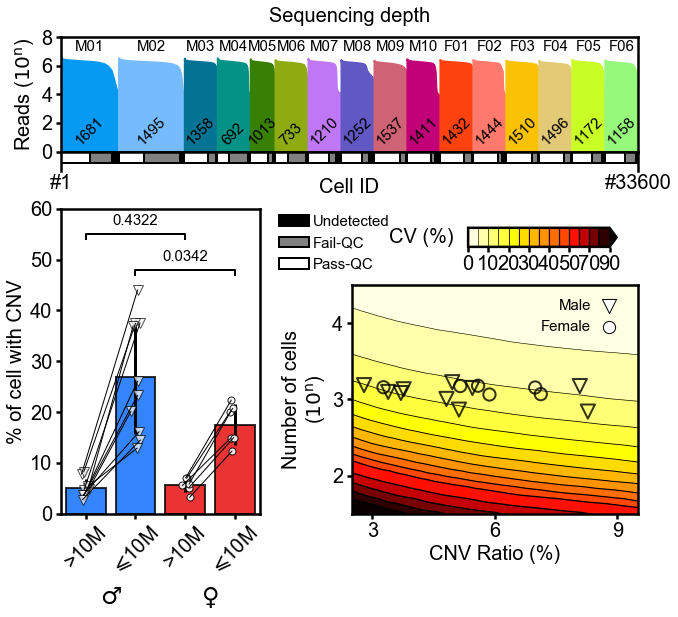

In [11]:
a4f = 2.5
width_a4f = 0.5
hight_a4f = 0.3

fig = plt.figure( figsize=(a4f*width_a4f*8.27, a4f*hight_a4f*11.69) )
gs = mpl.gridspec.GridSpec(nrows=25, ncols=20, figure=fig, hspace=0)

ax1  = fig.add_subplot(gs[ 0: 6,   :  ])
ax1b = fig.add_subplot(gs[ 6: 7,   :  ])

ax2  = fig.add_subplot(gs[ 9:25,  0:7 ])

axl  = fig.add_subplot(gs[  9:13, 10:  ])

ax3  = fig.add_subplot(gs[ 13:25, 10:  ])
ax3c = fig.add_subplot(gs[ 10:11, 14:  ])

n_ticks = fig1_barplot([ax1, ax1b], FSAMPLE=False)
fig2_plot(ax2, FSAMPLE=False)
_ = fig3_rainbow_plot(ax3, ax3c, axl, f=0, FSAMPLE=False)

handles, labels = ax1b.get_legend_handles_labels()
axl.legend(
    handles, labels, 
    loc='lower left', 
    bbox_to_anchor=(-0.3, 0),
    prop={'size':smallsize}, 
    handletextpad=0.2, 
    frameon=False
)

ax3.scatter(x=0, y=0, s=200, c='white', edgecolor='k', lw=1, marker='v', label='Male')
ax3.scatter(x=0, y=0, s=150, c='white', edgecolor='k', lw=1, marker='o', label='Female')

ax3.legend(
    loc='upper right',
    prop={'size':smallsize}, 
    handletextpad=0.2, 
    frameon=False,
    markerfirst=False
)

fig.savefig('A4_fig1.pdf', frameon=False, transparent=True, bbox_inches='tight')

plt.show()

---
---
---